# Convolutional Neural Networks for Hyperspectral Image Classification

Goals of the lecture:
1. Strengthen understanding of pixel-based classification for hyperspectral images
2. Simple 1D/2D-CNN architectures in PyTorch
3. Understand Dataset and DataLoader in PyTorch
4. Set-Up a training procedure with PyTorch
5. Train and evaluate neural networks

The Original Hyperspectral dataset is publicly available at [http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes). This notebook downloads the Pavia dataset automatically for you to "./data". Alternatively, you can download it as a zip file directly from the TUB-cloud: https://tubcloud.tu-berlin.de/s/j9KR2gR35wCGP87/download/PaviaU.zip)

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import requests
from tqdm.notebook import tqdm
from pathlib import Path


def download_file_with_progress(url: str, output_file: Path):
    """
    Given a `url` as a String and an `output_file` as a file-path the item will
    be downloaded and written to the `output_file`. If the `output_file` already
    exists, it will be overwritten.
    """
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))
    chunk_size = 2**20  # mb

    with open(output_file, "wb") as f:
        for data in tqdm(
            response.iter_content(chunk_size=chunk_size),
            total=total_size // chunk_size,
            unit="MB",
            unit_scale=True,
            desc="Downloading",
        ):
            f.write(data)

In [3]:
data_path = Path("./data")
data_path.mkdir(exist_ok=True)
# For quick prototyping there is on such things as _too many_ asserts!
assert data_path.exists, "Should exist after calling mkdir!"

## Download Dataset from Original Repo 

This notebook downloads "PaviaU" hyperspectral image and its corresponding ground reference map (class labels assigned per pixel). 

* "PaviaU" image includes 103 bands.

* Land cover map includes 9 classes 'Asphalt', 'Meadows', 'Gravel', 'Trees', \
'Painted metal sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows'.

**Note:** that in the classification map some areas are not labeled ('Undefined') that have to be excluded.

In [4]:
import zipfile
import scipy.io

In [5]:
class PaviaU():
    def __init__(self, base_dir: str):
        
        self.download_dataset(base_dir)
        self.datacube = self.normalize_img(self.open_datacube(base_dir))
        self.gt = self.open_gt(base_dir)

        self.class_names = np.array([
            "Undefined",
            "Asphalt",
            "Meadows",
            "Gravel",
            "Trees",
            "Painted metal sheets",
            "Bare Soil", 
            "Bitumen",
            "Self-Blocking Bricks",
            "Shadows"
        ])
        self.ignored_labels = [0]
        self.rgb_bands = (29, 19, 9)
        self.num_bands = self.datacube.shape[-1]
        self.num_classes = len(self.class_names) - len(self.ignored_labels)
    
    def download_dataset(self, base_dir: str):
        paviaU_path = base_dir / "PaviaU.zip"
        download_file_with_progress(
            "https://tubcloud.tu-berlin.de/s/j9KR2gR35wCGP87/download/PaviaU.zip",
            paviaU_path,
        )
        zipf = zipfile.ZipFile(paviaU_path)
        zipf.extractall(base_dir)
    
    def open_datacube(self, base_dir: str) -> np.array:
        image_path = base_dir /  "PaviaU/PaviaU.mat"
        return scipy.io.loadmat(image_path)["paviaU"]
    
    def open_gt(self, base_dir: str) -> np.array:
        gt_path = base_dir / "PaviaU/PaviaU_gt.mat"
        return scipy.io.loadmat(gt_path)["paviaU_gt"]
    
    def normalize_img(self, img: np.array) -> np.array:
        img = np.asarray(img, dtype="float32")
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        return img

In [6]:
pavia_u = PaviaU(data_path)

Downloading:   0%|          | 0.00/33.0 [00:00<?, ?MB/s]

In [7]:
pavia_u.datacube.shape

(610, 340, 103)

In [8]:
pavia_u.num_classes

9

## Visualization of the Image and Land Cover Map (Classification Map)

In [9]:
import matplotlib
import spectral

In [10]:
# create handles for legend
cmap = matplotlib.colormaps.get_cmap("tab10")
handles = [matplotlib.patches.Patch(color=cmap(i), label=pavia_u.class_names[i]) for i in range(10)]

In [11]:
def adjust_cmap(segmentation_map:np.array, cmap_name: str) -> matplotlib.colors.ListedColormap:
    "Adjust color pallette according to classes present in segmentation map."
    cmap = matplotlib.colormaps.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, cmap.N))
    adj_colors = colors[:np.max(segmentation_map) + 1]
    return matplotlib.colors.ListedColormap(adj_colors)

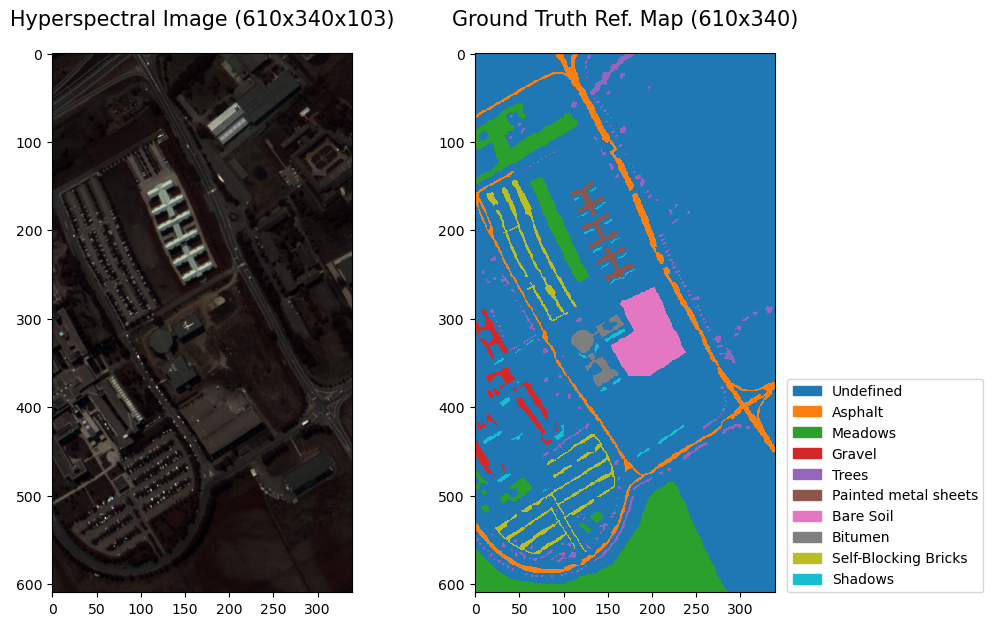

In [12]:
datacube_rgb = spectral.get_rgb(pavia_u.datacube, bands=pavia_u.rgb_bands)

fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title(
    "Hyperspectral Image ({}x{}x{})".format(*pavia_u.datacube.shape), fontsize=15, pad=20
)
axes[0].imshow(datacube_rgb)
axes[1].set_title("Ground Truth Ref. Map ({}x{})".format(*pavia_u.gt.shape), fontsize=15, pad=20)
axes[1].imshow(pavia_u.gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))
plt.show()

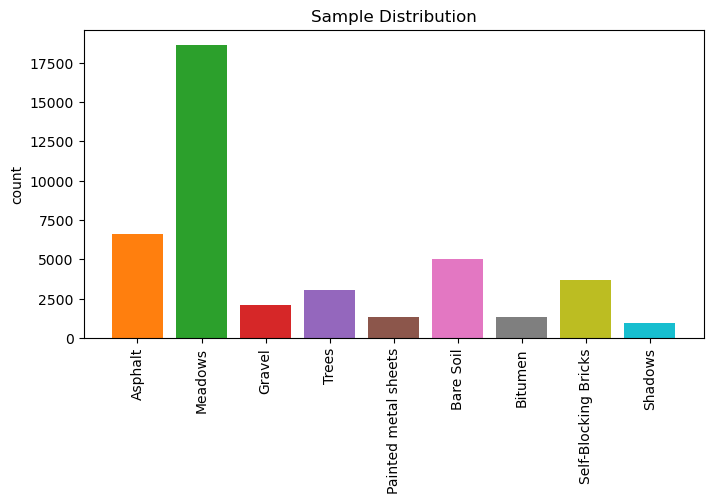

In [13]:
classes, counts = np.unique(pavia_u.gt, return_counts=True)

plt.figure(figsize=(8, 4))
plt.bar(
    classes[1:], counts[1:], tick_label=pavia_u.class_names[1:],
    color=adjust_cmap(pavia_u.gt, "tab10")(np.arange(1, 10))
)
plt.title('Sample Distribution')
plt.xticks(rotation=90)
plt.ylabel("count")
plt.show()

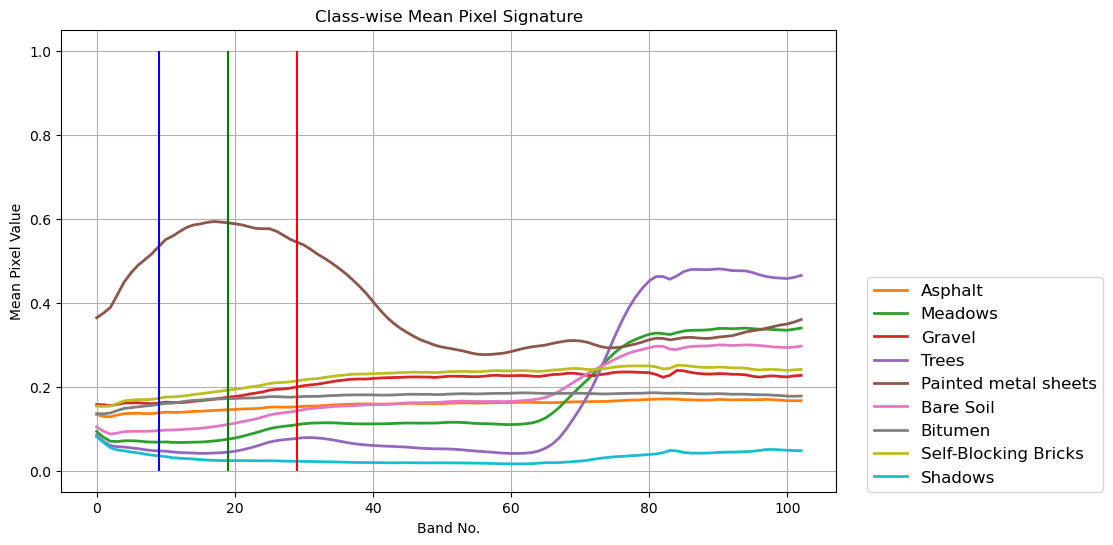

In [14]:
plt.figure(figsize=(10, 6))

for cl in range(1, 10):
    indices = np.nonzero(pavia_u.gt == cl)
    spectral_sig = pavia_u.datacube[indices].mean(axis=0)
    plt.plot(spectral_sig, label=pavia_u.class_names[cl], linewidth=2,
             color=adjust_cmap(pavia_u.gt, "tab10")(cl))

plt.title('Class-wise Mean Pixel Signature')
plt.legend(fontsize=12, loc=(1.04, 0))
plt.vlines(29, 0, 1, colors="r")
plt.vlines(19, 0, 1, colors="g")
plt.vlines(9, 0, 1, colors="b")
plt.xlabel("Band No.")
plt.ylabel("Mean Pixel Value")
plt.grid()

## Creating Train, Validation and Test sets

When training a neural network we need to create three sets namley one for train, on for validation and one for test purposes. After each training epoch we validate our model with the validation set. If the validation accuracy does not increase anymore, we store our best model, which we then evaluate on our test set.

In this pixel-based classification course each set (test/val/train) includes a certain number of samples (pixels). When using 2D or 3D convolutions each sample represents a pixel with its surroundings area (patch), and corresponding assigned class label. When using 1D convolutions each sample is just represented by its 103-band pixel.

For example for "CNN1D" each sample has 1x1x103 dimension (1x1 patch size and 103 spectral bands) and one label (between 0-9). For "CNN2D" each sample has 7x7x103 dimension (i.e., 7x7 patch size and 103 spectral bands).

In [15]:
def sample_gt(gt: np.array, train_percentage: float) -> (np.array, np.array):
    """
    Extract a fixed percentage of samples from an 2d-array of labels.

    Parameter
    ---------
    gt                : a 2D array of int labels
    train_percentage  : [0, 1] float

    Return
    ------
    train_gt, test_gt : 2D arrays of int labels

    """
    train_gt, test_gt = gt.copy(), gt.copy()

    for c in np.unique(gt):
        mask = gt == c
        for x in range(gt.shape[0]):
            first_half_count = np.count_nonzero(mask[:x, :])
            if first_half_count / np.count_nonzero(mask) > train_percentage:
                break

        train_mask = mask.copy()
        train_mask[:x, :] = 0
        train_gt[train_mask] = 0

        test_mask = mask.copy()
        test_mask[x:, :] = 0
        test_gt[test_mask] = 0

    return train_gt, test_gt

In [16]:
train_and_val_gt, test_gt = sample_gt(pavia_u.gt, 0.5)

n_train_and_val = np.count_nonzero(train_and_val_gt)
n_test = np.count_nonzero(test_gt)
n_total = np.count_nonzero(pavia_u.gt)

print("Train&Val:  {} samples selected (over {})".format(n_train_and_val, n_total))
print("Test:       {} samples selected (over {})".format(n_test, n_total))

Train&Val:  21478 samples selected (over 42776)
Test:       21298 samples selected (over 42776)


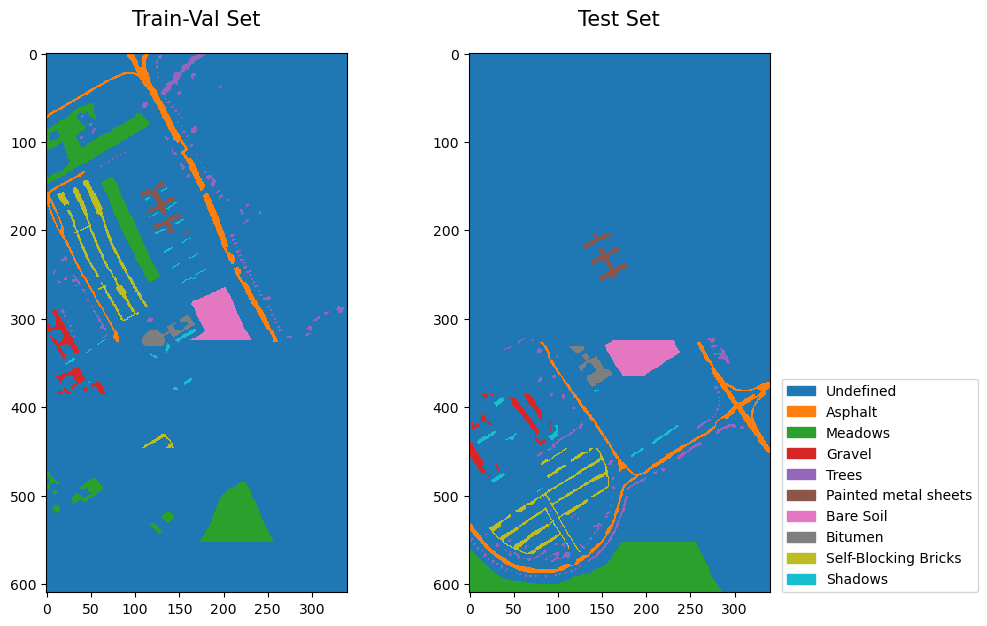

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("Train-Val Set", fontsize=15, pad=20)
axes[0].imshow(train_and_val_gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].set_title("Test Set", fontsize=15, pad=20)
axes[1].imshow(test_gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

In [18]:
# 2nd split: train - val split
train_gt, val_gt = sample_gt(train_and_val_gt, 0.8)

n_train = np.count_nonzero(train_gt)
n_val = np.count_nonzero(val_gt)

print("Train: {} samples selected (over {})".format(n_train, n_train_and_val))
print("Val:   {} samples selected (over {})".format(n_val, n_train_and_val))

Train: 17297 samples selected (over 21478)
Val:   4181 samples selected (over 21478)


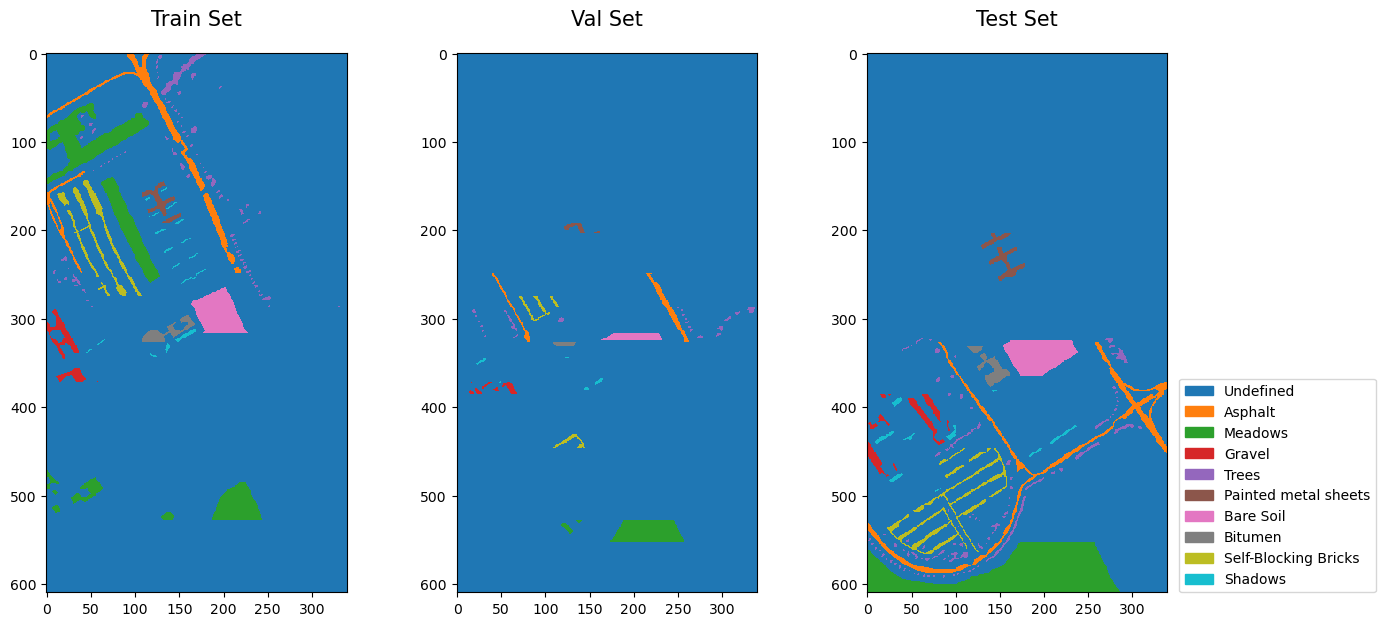

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
axes[0].set_title("Train Set", fontsize=15, pad=20)
axes[0].imshow(train_gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].set_title("Val Set", fontsize=15, pad=20)
axes[1].imshow(val_gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[2].set_title("Test Set", fontsize=15, pad=20)
axes[2].imshow(test_gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[2].legend(handles=handles, loc=(1.04, 0))

# Define CNN Architectures

With PyTorch you can build and add your own neural network architecture. In general, bulding a Neural network in PyTorch includes 3 main steps:
* Extend the nn.Module base class (e.g., class name_you_want(nn.Module))
* Define layers as class attributes
* Implement the forward() method

for more info check Pytorch documentation:

[https://pytorch.org/docs/master/nn.html#](https://pytorch.org/docs/master/nn.html#)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
?nn.Module

Init signature: nn.Module() -> None
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made before assignment on the child.

:ivar training: Boolean represents whether this module is in training or
                evaluation mode.


In [22]:
?nn.Conv1d

Init signature:
nn.Conv1d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int]],
    stride: Union[int, Tuple[int]] = 1,
    padding: Union[str, int, Tuple[int]] = 0,
    dilation: Union[int, Tuple[int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 1D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, L)` and output :math:`(N, C_{\text{out}}, L_{\text{out}})` can be
precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{in} - 1} \text{weight}(C_{\text{out}_j}, k)
    \star \text{input}(N_i, k)

where :math:`\star` is the valid `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:math:`L` is a length of signal sequence.


Thi

In [23]:
?nn.MaxPool1d

Init signature:
nn.MaxPool1d(
    kernel_size: Union[int, Tuple[int, ...]],
    stride: Union[int, Tuple[int, ...], NoneType] = None,
    padding: Union[int, Tuple[int, ...]] = 0,
    dilation: Union[int, Tuple[int, ...]] = 1,
    return_indices: bool = False,
    ceil_mode: bool = False,
) -> None
Docstring:     
Applies a 1D max pooling over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size :math:`(N, C, L)`
and output :math:`(N, C, L_{out})` can be precisely described as:

.. math::
    out(N_i, C_j, k) = \max_{m=0, \ldots, \text{kernel\_size} - 1}
            input(N_i, C_j, stride \times k + m)

If :attr:`padding` is non-zero, then the input is implicitly padded with negative infinity on both sides
for :attr:`padding` number of points. :attr:`dilation` is the stride between the elements within the
sliding window. This `link`_ has a nice visualization of the pooling parameters.

Note:
    When ceil_mode=True, slid

In [24]:
class CNN1D(nn.Module):
    def __init__(self, width, num_classes, num_filter=10):
        super(CNN1D, self).__init__()
        self.width = width

        # 10 filter with kernel of size 12 x 1
        self.conv1 = nn.Conv1d(1, num_filter, kernel_size=(12,))
        self.pool1 = nn.MaxPool1d((3,))
        self.conv2 = nn.Conv1d(num_filter, num_filter, kernel_size=(12,))
        self.features_size = self._get_final_flattened_size()

        self.fc = nn.Linear(self.features_size, num_classes)
        #self.apply(self.weight_init)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = x.reshape(-1, self.features_size)
        x = self.fc(x)
        return x

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, self.width)
            x = F.relu(self.conv1(x))
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
        return x.numel()  # multiply shape

In [25]:
cnn1d = CNN1D(pavia_u.num_bands, pavia_u.num_classes)

In [26]:
from torchinfo import summary

summary(cnn1d, input_size=(1, 103), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CNN1D                                    [1, 103]                  [1, 9]                    --
├─Conv1d: 1-1                            [1, 103]                  [10, 92]                  130
├─MaxPool1d: 1-2                         [10, 92]                  [10, 30]                  --
├─Conv1d: 1-3                            [10, 30]                  [10, 19]                  1,210
├─Linear: 1-4                            [1, 190]                  [1, 9]                    1,719
Total params: 3,059
Trainable params: 3,059
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

### Example how for different data the input/outputs of layers change

In [27]:
?summary

Signature:
summary(
    model: 'nn.Module',
    input_size: 'INPUT_SIZE_TYPE | None' = None,
    input_data: 'INPUT_DATA_TYPE | None' = None,
    batch_dim: 'int | None' = None,
    cache_forward_pass: 'bool | None' = None,
    col_names: 'Iterable[str] | None' = None,
    col_width: 'int' = 25,
    depth: 'int' = 3,
    device: 'torch.device | str | None' = None,
    dtypes: 'list[torch.dtype] | None' = None,
    mode: 'str | None' = None,
    row_settings: 'Iterable[str] | None' = None,
    verbose: 'int | None' = None,
    **kwargs: 'Any',
) -> 'ModelStatistics'
Docstring:
Summarize the given PyTorch model. Summarized information includes:
    1) Layer names,
    2) input/output shapes,
    3) kernel shape,
    4) # of parameters,
    5) # of operations (Mult-Adds),
    6) whether layer is trainable

NOTE: If neither input_data or input_size are provided, no forward pass through the
network is performed, and the provided model information is limited to layer names.

Args:
    model 

In [28]:
summary(CNN1D(50, 100), input_size=(1, 50), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CNN1D                                    [1, 50]                   [1, 100]                  --
├─Conv1d: 1-1                            [1, 50]                   [10, 39]                  130
├─MaxPool1d: 1-2                         [10, 39]                  [10, 13]                  --
├─Conv1d: 1-3                            [10, 13]                  [10, 2]                   1,210
├─Linear: 1-4                            [1, 20]                   [1, 100]                  2,100
Total params: 3,440
Trainable params: 3,440
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

# Define Training Hyperparameter

In [29]:
def get_device(cuda_no):
    return torch.device('cpu') if cuda_no < 0 else torch.device(args.cuda_no)

In [72]:
# fmt: off
device         = torch.device("mps")
patch_size     = 1  # 1 for 1D-CNN, 7 for 2D-CNN
batch_size     = 100
learning_rate  = 0.01
epochs         = 20
# fmt: on

In [31]:
import torch.optim as optim

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    cnn1d.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=0.0005,
    nesterov=True,
)

# Set-Up Dataset and DataLoader

In [32]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from typing import List

In [33]:
?DataLoader

Init signature:
DataLoader(
    dataset: torch.utils.data.dataset.Dataset[+T_co],
    batch_size: Optional[int] = 1,
    shuffle: Optional[bool] = None,
    sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None,
    batch_sampler: Union[torch.utils.data.sampler.Sampler[Sequence], Iterable[Sequence], NoneType] = None,
    num_workers: int = 0,
    collate_fn: Optional[Callable[[List[~T]], Any]] = None,
    pin_memory: bool = False,
    drop_last: bool = False,
    timeout: float = 0,
    worker_init_fn: Optional[Callable[[int], NoneType]] = None,
    multiprocessing_context=None,
    generator=None,
    *,
    prefetch_factor: int = 2,
    persistent_workers: bool = False,
    pin_memory_device: str = '',
)
Docstring:     
Data loader. Combines a dataset and a sampler, and provides an iterable over
the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process loading, customizing
load

In [34]:
?Dataset

Init signature: Dataset()
Docstring:     
An abstract class representing a :class:`Dataset`.

All datasets that represent a map from keys to data samples should subclass
it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
data sample for a given key. Subclasses could also optionally overwrite
:meth:`__len__`, which is expected to return the size of the dataset by many
:class:`~torch.utils.data.Sampler` implementations and the default options
of :class:`~torch.utils.data.DataLoader`.

.. note::
  :class:`~torch.utils.data.DataLoader` by default constructs a index
  sampler that yields integral indices.  To make it work with a map-style
  dataset with non-integral indices/keys, a custom sampler must be provided.
File:           ~/micromamba/envs/ip4rs24/lib/python3.9/site-packages/torch/utils/data/dataset.py
Type:           type
Subclasses:     IterableDataset, TensorDataset, ConcatDataset, Subset, MapDataPipe

In [35]:
class PaviaUDataset(Dataset):
    
    def __init__(self, datacube: np.array, gt: np.array, ignored_labels: List[int] = [], patch_size: int = 1):
        
        self.datacube = datacube
        self.gt = gt
        self.coordinates = []
        self.patch_size = patch_size

        self.ignored_labels = ignored_labels
        self.active_classes = list(set(np.unique(self.gt)) - set(self.ignored_labels))
        self.num_active_classes = len(self.active_classes)
        self.active2squeezed = dict(zip(self.active_classes, range(self.num_active_classes)))
        self.squeezed2active = {v: k for k, v in self.active2squeezed.items()}
        
        self.readout_active_coordinates()
        
    def readout_active_coordinates(self):
        h, w, _ = self.datacube.shape
        
        active_classes_mask = np.zeros((h, w))
        for cl in self.active_classes:
            active_classes_mask[self.gt == cl] = 1
        
        x_pos, y_pos = np.nonzero(active_classes_mask)
        p = self.patch_size // 2
        self.coordinates = [
            (x, y)
            for x, y in zip(x_pos, y_pos)
            if x > p and x < h - p and y > p and y < w - p
        ]   
        
    def __getitem__(self, idx: int):
        x_cord, y_cord = self.coordinates[idx]
        target = self.gt[x_cord, y_cord]
        target = self.active2squeezed[target]

        if self.patch_size == 1:
            sample = self.datacube[x_cord, y_cord]
            # add channel dim that is always = 1
            sample = sample[np.newaxis, :]
        else:
            x1, y1 = x_cord - self.patch_size // 2, y_cord - self.patch_size // 2
            x2, y2 = x1 + self.patch_size, y1 + self.patch_size
            sample = self.datacube[x1:x2, y1:y2]
            
            # move channels to first axis (required by PyTorch)
            sample = np.moveaxis(sample, -1, 0)
            
        return sample, target, x_cord, y_cord
    
    def __len__(self):
        return len(self.coordinates)

In [36]:
train_dataset = PaviaUDataset(pavia_u.datacube, train_gt, pavia_u.ignored_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = PaviaUDataset(pavia_u.datacube, val_gt, pavia_u.ignored_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = PaviaUDataset(pavia_u.datacube, test_gt, pavia_u.ignored_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [37]:
from tqdm.notebook import tqdm

def train(
    model: nn.Module,
    optimizer: torch.optim,
    criterion: torch.nn.modules.loss,
    train_loader: DataLoader,
    epochs: int,
    device: torch.device,
    val_loader: DataLoader = None,
):
    """
    Training loop to optimize a network for several epochs and a specified loss.

    Args:
    -----
    model               : a PyTorch model
    optimizer           : a PyTorch optimizer
    criterion           : a PyTorch-compatible loss function, e.g. nn.CrossEntropyLoss
    train_loader        : a PyTorch trainset loader
    epochs              : int specifying the number of training epochs
    device              : torch device to use (defaults to CPU)
    val_loader (opt.)   : validation dataset
    """
    model.to(device)  # put model on device
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in tqdm(range(1, epochs + 1), desc="Training the network"):
        model.train()  # set model to training mode
        train_losses_epoch = []
        train_targets = []
        train_preds = []

        # Data-Loading Loop
        with tqdm(train_loader, unit=" batch") as tepoch:
            for idx, (data, targets, _, _) in enumerate(tepoch):
                tepoch.set_description("Epoch {}".format(epoch))

                # put loaded data and targets on device
                data, targets = data.to(device), targets.to(device)

                # zero accumulated gradients from previous batch
                optimizer.zero_grad()

                # infer predictions for batch
                output = model(data)
                predictions = output.argmax(dim=1)

                # compute loss from predictions, CELoss automatically applies F.log_softmax
                loss = criterion(output, targets)

                # accumulate gradients for all parameter according to batch errors
                loss.backward()

                # update paramters according to accumulated gradients
                optimizer.step()
                
                train_losses_epoch.append(loss.item())
                train_targets.append(targets)
                train_preds.append(predictions)
            
            curr_train_loss = np.mean(train_losses_epoch)
            train_targets = torch.cat(train_targets)
            train_preds = torch.cat(train_preds)
            
            correct = (train_preds == train_targets).sum().item()  # get value from tensor
            train_accuracy = correct / len(train_loader.dataset)
            train_losses.append(curr_train_loss)
            train_accuracies.append(train_accuracy)
            
            print("Train-Loss: {:.2f}. Train-Acc: {:.2f}".format(curr_train_loss, train_accuracy))

        if val_loader is not None:
            model.eval()
            val_losses_epoch = []
            val_targets = []
            val_preds = []

            with torch.no_grad():
                for data, targets, _, _ in val_loader:
                    # put loaded data and targets on device
                    data = data.to(device)
                    targets = targets.to(device)

                    output = model(data)
                    loss = criterion(output, targets)
                    predictions = output.argmax(dim=1)
                    
                    val_losses_epoch.append(loss.item())
                    val_targets.append(targets)
                    val_preds.append(predictions)
                    
            curr_val_loss = np.mean(val_losses_epoch)
            val_targets = torch.cat(val_targets)
            val_preds = torch.cat(val_preds)

            correct = (val_preds == val_targets).sum().item()
            val_accuracy = correct / len(val_loader.dataset)
            val_losses.append(curr_val_loss)
            val_accuracies.append(val_accuracy)

            print("Val-Loss:   {:.2f}. Val-Acc:   {:.2f}".format(curr_val_loss, val_accuracy))

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def test(
    model: nn.Module,
    test_loader: DataLoader,
    class_names: List[str],
    device: torch.device,
):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for idx, (data, target, _, _) in enumerate(tqdm(test_loader, desc="Test: ")):
            # put loaded data and targets on device
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            predicted = output.argmax(dim=1)

            predictions += predicted.tolist()
            targets += target.tolist()

    results = {}

    if class_names is None:
        class_names = range(len(np.unique(targets)))

    cm = confusion_matrix(targets, predictions)

    results["cm"] = cm
    results["overall_acc"] = accuracy_score(targets, predictions)
    results["report"] = classification_report(
        targets,
        predictions,
        target_names=class_names,
        zero_division=0,
        digits=2,
    )

    return results

In [39]:
train(
    model=cnn1d,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    epochs=epochs,
    device=device,
    val_loader=val_loader,
)

Training the network:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 1.49. Train-Acc: 0.50
Val-Loss:   0.75. Val-Acc:   0.70


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.73. Train-Acc: 0.74
Val-Loss:   0.84. Val-Acc:   0.70


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.61. Train-Acc: 0.78
Val-Loss:   0.60. Val-Acc:   0.76


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.55. Train-Acc: 0.80
Val-Loss:   1.23. Val-Acc:   0.42


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.51. Train-Acc: 0.82
Val-Loss:   0.66. Val-Acc:   0.76


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.47. Train-Acc: 0.84
Val-Loss:   0.54. Val-Acc:   0.76


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.45. Train-Acc: 0.84
Val-Loss:   0.52. Val-Acc:   0.81


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.43. Train-Acc: 0.85
Val-Loss:   0.67. Val-Acc:   0.74


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.41. Train-Acc: 0.86
Val-Loss:   0.73. Val-Acc:   0.64


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.39. Train-Acc: 0.87
Val-Loss:   1.12. Val-Acc:   0.50


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.39. Train-Acc: 0.87
Val-Loss:   0.36. Val-Acc:   0.86


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.37. Train-Acc: 0.87
Val-Loss:   0.62. Val-Acc:   0.75


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.36. Train-Acc: 0.87
Val-Loss:   1.58. Val-Acc:   0.44


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.36. Train-Acc: 0.87
Val-Loss:   0.47. Val-Acc:   0.77


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.35. Train-Acc: 0.88
Val-Loss:   0.69. Val-Acc:   0.69


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.35. Train-Acc: 0.88
Val-Loss:   0.86. Val-Acc:   0.60


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.34. Train-Acc: 0.88
Val-Loss:   0.42. Val-Acc:   0.82


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.34. Train-Acc: 0.88
Val-Loss:   0.81. Val-Acc:   0.57


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.34. Train-Acc: 0.88
Val-Loss:   0.42. Val-Acc:   0.80


  0%|          | 0/173 [00:00<?, ? batch/s]

Train-Loss: 0.33. Train-Acc: 0.89
Val-Loss:   0.58. Val-Acc:   0.72


## Evaluate - Visualization of Predicted Map

In [40]:
full_dataset = PaviaUDataset(pavia_u.datacube, pavia_u.gt, pavia_u.ignored_labels)
full_loader = DataLoader(full_dataset, batch_size=100)

In [41]:
def infer_image(
    model: nn.Module,
    full_loader: DataLoader,
    class_names: List[str],
    device: torch.device,
    gt: np.array,
):  
    model.eval()
    output = np.zeros(gt.shape)
    
    predictions = []
    targets_list = []
    x_cords_list = []
    y_cords_list = []
    
    with torch.no_grad():
        for idx, (batch, targets, x_cord, y_cord) in enumerate(tqdm(full_loader, desc="Inference on whole image: ")):
            # put loaded data on GPU
            batch = batch.to(device)

            logits = model(batch)
            probs = F.softmax(logits, dim=1)
            _, predicted = torch.max(probs.data, 1)
            predictions += predicted.tolist()
            targets_list += targets
            x_cords_list += x_cord
            y_cords_list += y_cord
    
    for i, pred in enumerate(predictions):
        output[x_cords_list[i], y_cords_list[i]] = full_loader.dataset.squeezed2active[pred]
    
    return output

In [42]:
active_cl_names = pavia_u.class_names[test_dataset.active_classes]

In [43]:
prediction = infer_image(cnn1d, full_loader, active_cl_names, device, pavia_u.gt)

Inference on whole image:   0%|          | 0/427 [00:00<?, ?it/s]

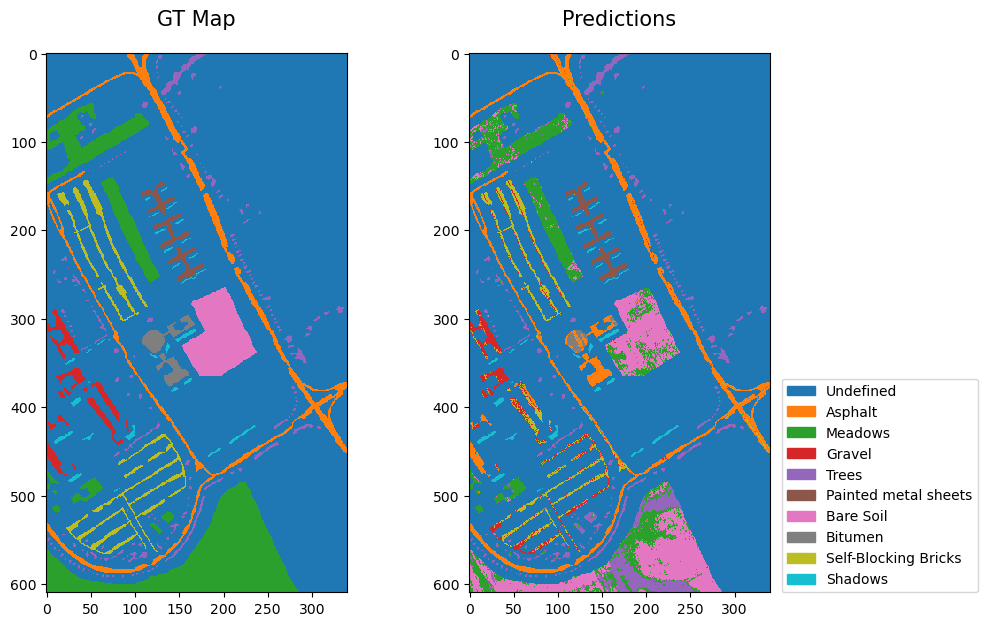

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("GT Map", fontsize=15, pad=20)
axes[0].imshow(pavia_u.gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].set_title("Predictions", fontsize=15, pad=20)
axes[1].imshow(prediction, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

## Evaluate - Metrics

In [45]:
import pandas as pd
import seaborn as sns

In [46]:
results = test(cnn1d, test_loader, active_cl_names, device)

Test:   0%|          | 0/213 [00:00<?, ?it/s]

In [47]:
print(results["report"])

                      precision    recall  f1-score   support

             Asphalt       0.74      0.90      0.81      3301
             Meadows       0.67      0.20      0.31      9246
              Gravel       0.28      0.28      0.28      1031
               Trees       0.44      0.98      0.60      1531
Painted metal sheets       1.00      1.00      1.00       666
           Bare Soil       0.22      0.64      0.33      2487
             Bitumen       0.43      0.10      0.16       660
Self-Blocking Bricks       0.65      0.56      0.60      1833
             Shadows       0.99      1.00      1.00       473

            accuracy                           0.49     21228
           macro avg       0.60      0.63      0.56     21228
        weighted avg       0.60      0.49      0.47     21228



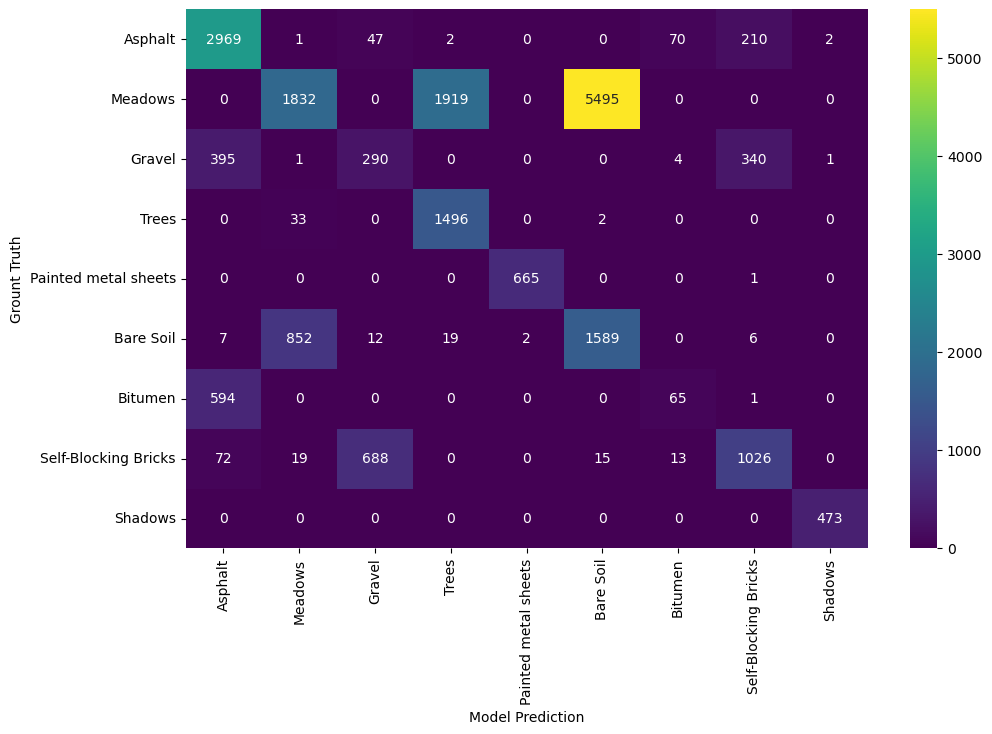

In [48]:
plt.subplots(1, 1, figsize=(11, 7))
ax = sns.heatmap(
    results["cm"],
    cmap="viridis",
    fmt="g",
    xticklabels=active_cl_names,
    yticklabels=active_cl_names,
    annot=True,
)
ax.set(xlabel="Model Prediction", ylabel="Grount Truth")
plt.show()

## In-course practice I

Use the model `CNN2D` for training and instantiate it with 18 filters. This model is a deep network with 2D convolution layer which requires 103x7x7 patches. 

What you need to do:

- Change the patch size
- Intantiate the new model and re-intantiate the optimizer and data loaders
- Train and evaluate the model

In [76]:
class CNN2D(nn.Module):
    def __init__(self, input_size, num_classes, num_filter=2):
        super(CNN2D, self).__init__()
        self.input_size = input_size

        self.conv1 = nn.Conv2d(input_size[0], num_filter, kernel_size=(3, 3), padding=1)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(num_filter, 2 * num_filter, kernel_size=(3, 3), padding=0)
        self.features_size = self._get_final_flattened_size()

        self.fc = nn.Linear(self.features_size, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = x.reshape(-1, self.features_size)
        x = self.fc(x)
        return x

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros((1, *self.input_size))
            x = F.relu(self.conv1(x))
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
        return x.numel()  # multiply shape

In [77]:
pavia_u.num_bands, pavia_u.num_classes, pavia_u.datacube.shape

(103, 9, (610, 340, 103))

In [78]:
cnn2d = CNN2D((103,7,7), pavia_u.num_classes)

In [79]:
summary(cnn2d, input_size=(103, 7, 7), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CNN2D                                    [103, 7, 7]               [1, 9]                    --
├─Conv2d: 1-1                            [103, 7, 7]               [2, 7, 7]                 1,856
├─MaxPool2d: 1-2                         [2, 7, 7]                 [2, 3, 3]                 --
├─Conv2d: 1-3                            [2, 3, 3]                 [4, 1, 1]                 76
├─Linear: 1-4                            [1, 4]                    [1, 9]                    45
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.02
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.03

In [80]:
optimizer = optim.SGD(
    cnn2d.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=0.0005,
    nesterov=True,
)

In [81]:
patch_size=7

train_dataset = PaviaUDataset(pavia_u.datacube, train_gt, pavia_u.ignored_labels, patch_size=patch_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = PaviaUDataset(pavia_u.datacube, val_gt, pavia_u.ignored_labels, patch_size=patch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = PaviaUDataset(pavia_u.datacube, test_gt, pavia_u.ignored_labels, patch_size=patch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [82]:
train(
    model=cnn2d,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    epochs=epochs,
    device=device,
    val_loader=val_loader,
)

Training the network:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 1.41. Train-Acc: 0.50
Val-Loss:   1.13. Val-Acc:   0.60


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 1.10. Train-Acc: 0.61
Val-Loss:   0.94. Val-Acc:   0.63


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.93. Train-Acc: 0.64
Val-Loss:   0.86. Val-Acc:   0.67


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.81. Train-Acc: 0.70
Val-Loss:   0.74. Val-Acc:   0.72


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.69. Train-Acc: 0.75
Val-Loss:   0.68. Val-Acc:   0.74


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.63. Train-Acc: 0.77
Val-Loss:   0.62. Val-Acc:   0.77


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.59. Train-Acc: 0.79
Val-Loss:   0.60. Val-Acc:   0.77


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.55. Train-Acc: 0.80
Val-Loss:   0.63. Val-Acc:   0.76


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.52. Train-Acc: 0.80
Val-Loss:   0.54. Val-Acc:   0.78


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.50. Train-Acc: 0.81
Val-Loss:   0.53. Val-Acc:   0.78


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.48. Train-Acc: 0.82
Val-Loss:   0.54. Val-Acc:   0.80


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.46. Train-Acc: 0.84
Val-Loss:   0.50. Val-Acc:   0.82


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.43. Train-Acc: 0.85
Val-Loss:   0.50. Val-Acc:   0.80


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.41. Train-Acc: 0.86
Val-Loss:   0.52. Val-Acc:   0.81


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.39. Train-Acc: 0.87
Val-Loss:   0.47. Val-Acc:   0.82


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.37. Train-Acc: 0.87
Val-Loss:   0.51. Val-Acc:   0.82


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.35. Train-Acc: 0.88
Val-Loss:   0.50. Val-Acc:   0.83


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.34. Train-Acc: 0.89
Val-Loss:   0.56. Val-Acc:   0.74


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.33. Train-Acc: 0.89
Val-Loss:   0.58. Val-Acc:   0.70


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.32. Train-Acc: 0.89
Val-Loss:   0.59. Val-Acc:   0.69


In [85]:
full_dataset = PaviaUDataset(pavia_u.datacube, pavia_u.gt, pavia_u.ignored_labels, patch_size=patch_size)
full_loader = DataLoader(full_dataset, batch_size=100)

In [86]:
prediction = infer_image(cnn2d, full_loader, active_cl_names, device, pavia_u.gt)

Inference on whole image:   0%|          | 0/412 [00:00<?, ?it/s]

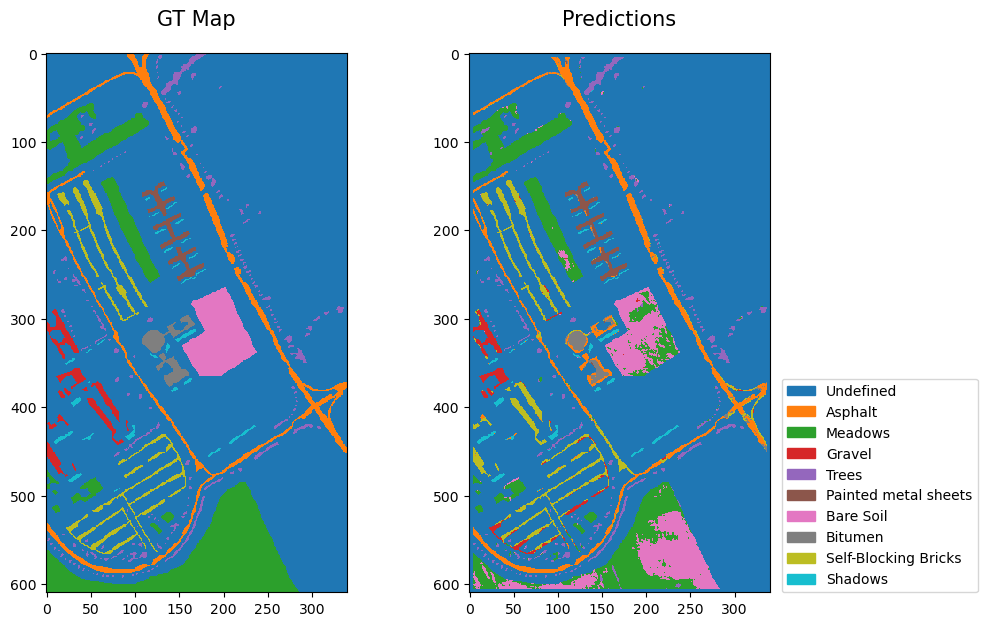

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("GT Map", fontsize=15, pad=20)
axes[0].imshow(pavia_u.gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].set_title("Predictions", fontsize=15, pad=20)
axes[1].imshow(prediction, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

In [88]:
results = test(cnn2d, test_loader, active_cl_names, device)

Test:   0%|          | 0/201 [00:00<?, ?it/s]

In [89]:
print(results["report"])

                      precision    recall  f1-score   support

             Asphalt       0.85      0.76      0.80      3226
             Meadows       0.80      0.47      0.60      8262
              Gravel       0.06      0.03      0.04       967
               Trees       0.94      0.92      0.93      1525
Painted metal sheets       0.99      0.95      0.97       666
           Bare Soil       0.28      0.67      0.39      2487
             Bitumen       0.64      0.49      0.55       660
Self-Blocking Bricks       0.46      0.69      0.55      1833
             Shadows       0.97      0.96      0.97       473

            accuracy                           0.60     20099
           macro avg       0.67      0.66      0.65     20099
        weighted avg       0.69      0.60      0.62     20099



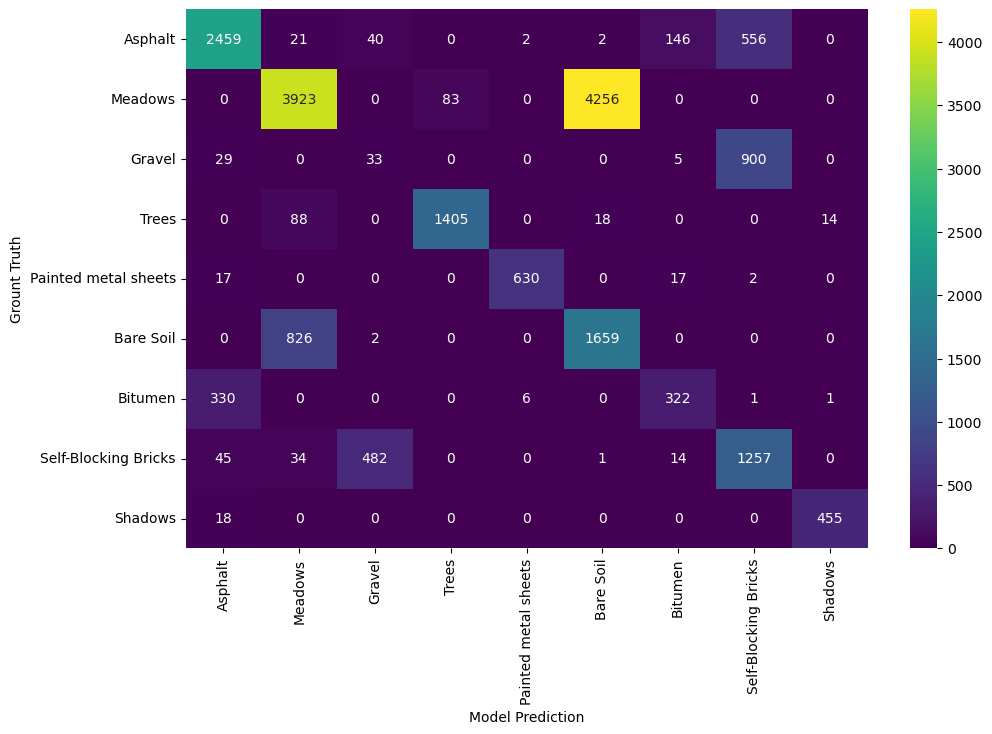

In [90]:
plt.subplots(1, 1, figsize=(11, 7))
ax = sns.heatmap(
    results["cm"],
    cmap="viridis",
    fmt="g",
    xticklabels=active_cl_names,
    yticklabels=active_cl_names,
    annot=True,
)
ax.set(xlabel="Model Prediction", ylabel="Grount Truth")
plt.show()

## In-course practice II

Add one `Conv2D` layer and one `AvgPool2D` layer to the 2D-CNN and retrain the network. Therefore, alternate the padding of `conv2` to 1 and add the `conv3` with input and output filter size `2 * num_filter`, a kernel of (3, 3) and a padding of 1. The `AvgPool2D` should be of kernel size (3, 3). Activate the third `Conv2D` with a ReLU function (like for `conv1` and `conv2`).

More information on parameters for the convolutional layer and the respective impact on the output shape can be found in the documentation of PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [107]:
class CNN2D_custom(nn.Module):
    def __init__(self, input_size, num_classes, num_filter=2):
        super(CNN2D_custom, self).__init__()
        self.input_size = input_size

        self.conv1 = nn.Conv2d(input_size[0], num_filter, kernel_size=(3, 3), padding=1)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(num_filter, 2 * num_filter, kernel_size=(3, 3), padding=1)
        self.avg_pool = nn.AvgPool2d((3,3))
        self.conv3 = nn.Conv2d(2 * num_filter, 2 * num_filter, kernel_size=(3, 3), padding=1)
        self.features_size = self._get_final_flattened_size()

        self.fc = nn.Linear(self.features_size, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.avg_pool(x)
        x = F.relu(self.conv3(x))
        x = x.reshape(-1, self.features_size)
        x = self.fc(x)
        return x

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros((1, *self.input_size))
            x = F.relu(self.conv1(x))
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
            x = self.avg_pool(x)
            x = F.relu(self.conv3(x))
        return x.numel()  # multiply shape

In [108]:
cnn2d_custom = CNN2D_custom((103, 7, 7), pavia_u.num_classes)

In [109]:
summary(cnn2d_custom, input_size=(103, 7, 7), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CNN2D_custom                             [103, 7, 7]               [1, 9]                    --
├─Conv2d: 1-1                            [103, 7, 7]               [2, 7, 7]                 1,856
├─MaxPool2d: 1-2                         [2, 7, 7]                 [2, 3, 3]                 --
├─Conv2d: 1-3                            [2, 3, 3]                 [4, 3, 3]                 76
├─AvgPool2d: 1-4                         [4, 3, 3]                 [4, 1, 1]                 --
├─Conv2d: 1-5                            [4, 1, 1]                 [4, 1, 1]                 148
├─Linear: 1-6                            [1, 4]                    [1, 9]                    45
Total params: 2,125
Trainable params: 2,125
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.02
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.03

In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    cnn2d_custom.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=0.0005,
    nesterov=True,
)

In [111]:
train(
    model=cnn2d_custom,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    epochs=epochs,
    device=device,
    val_loader=val_loader,
)

Training the network:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 1.83. Train-Acc: 0.43
Val-Loss:   1.75. Val-Acc:   0.44


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 1.76. Train-Acc: 0.43
Val-Loss:   1.74. Val-Acc:   0.44


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 1.74. Train-Acc: 0.43
Val-Loss:   1.63. Val-Acc:   0.44


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 1.47. Train-Acc: 0.49
Val-Loss:   1.30. Val-Acc:   0.59


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 1.21. Train-Acc: 0.60
Val-Loss:   1.09. Val-Acc:   0.63


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 1.08. Train-Acc: 0.62
Val-Loss:   1.03. Val-Acc:   0.63


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 1.04. Train-Acc: 0.62
Val-Loss:   0.99. Val-Acc:   0.63


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 1.01. Train-Acc: 0.62
Val-Loss:   0.97. Val-Acc:   0.63


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.96. Train-Acc: 0.62
Val-Loss:   0.91. Val-Acc:   0.64


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.90. Train-Acc: 0.64
Val-Loss:   0.86. Val-Acc:   0.69


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.84. Train-Acc: 0.68
Val-Loss:   0.81. Val-Acc:   0.70


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.80. Train-Acc: 0.69
Val-Loss:   0.77. Val-Acc:   0.71


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.77. Train-Acc: 0.70
Val-Loss:   0.74. Val-Acc:   0.72


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.74. Train-Acc: 0.72
Val-Loss:   0.72. Val-Acc:   0.74


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.73. Train-Acc: 0.73
Val-Loss:   0.70. Val-Acc:   0.73


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.71. Train-Acc: 0.73
Val-Loss:   0.69. Val-Acc:   0.74


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.70. Train-Acc: 0.74
Val-Loss:   0.69. Val-Acc:   0.73


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.69. Train-Acc: 0.74
Val-Loss:   0.70. Val-Acc:   0.73


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.68. Train-Acc: 0.74
Val-Loss:   0.65. Val-Acc:   0.74


  0%|          | 0/169 [00:00<?, ? batch/s]

Train-Loss: 0.67. Train-Acc: 0.74
Val-Loss:   0.66. Val-Acc:   0.74


In [112]:
prediction = infer_image(cnn2d_custom, full_loader, active_cl_names, device, pavia_u.gt)

Inference on whole image:   0%|          | 0/412 [00:00<?, ?it/s]

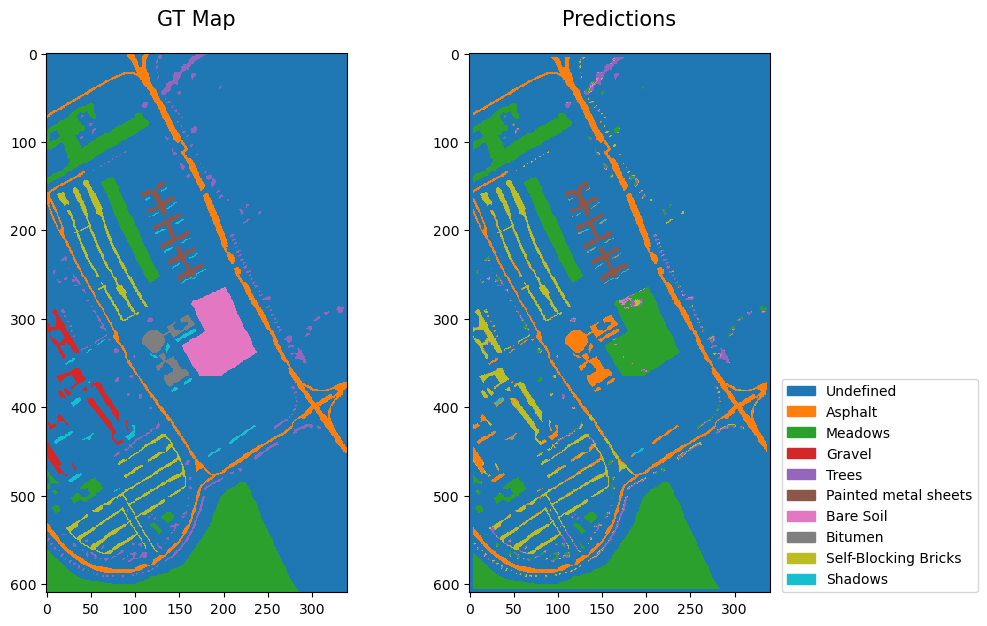

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("GT Map", fontsize=15, pad=20)
axes[0].imshow(pavia_u.gt, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].set_title("Predictions", fontsize=15, pad=20)
axes[1].imshow(prediction, cmap=adjust_cmap(pavia_u.gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

In [114]:
results = test(cnn2d_custom, test_loader, active_cl_names, device)

Test:   0%|          | 0/201 [00:00<?, ?it/s]

In [115]:
print(results["report"])

                      precision    recall  f1-score   support

             Asphalt       0.64      0.92      0.75      3226
             Meadows       0.75      1.00      0.86      8262
              Gravel       0.00      0.00      0.00       967
               Trees       0.87      0.49      0.63      1525
Painted metal sheets       1.00      1.00      1.00       666
           Bare Soil       0.11      0.00      0.01      2487
             Bitumen       0.00      0.00      0.00       660
Self-Blocking Bricks       0.54      0.79      0.64      1833
             Shadows       1.00      0.13      0.24       473

            accuracy                           0.70     20099
           macro avg       0.55      0.48      0.46     20099
        weighted avg       0.60      0.70      0.62     20099



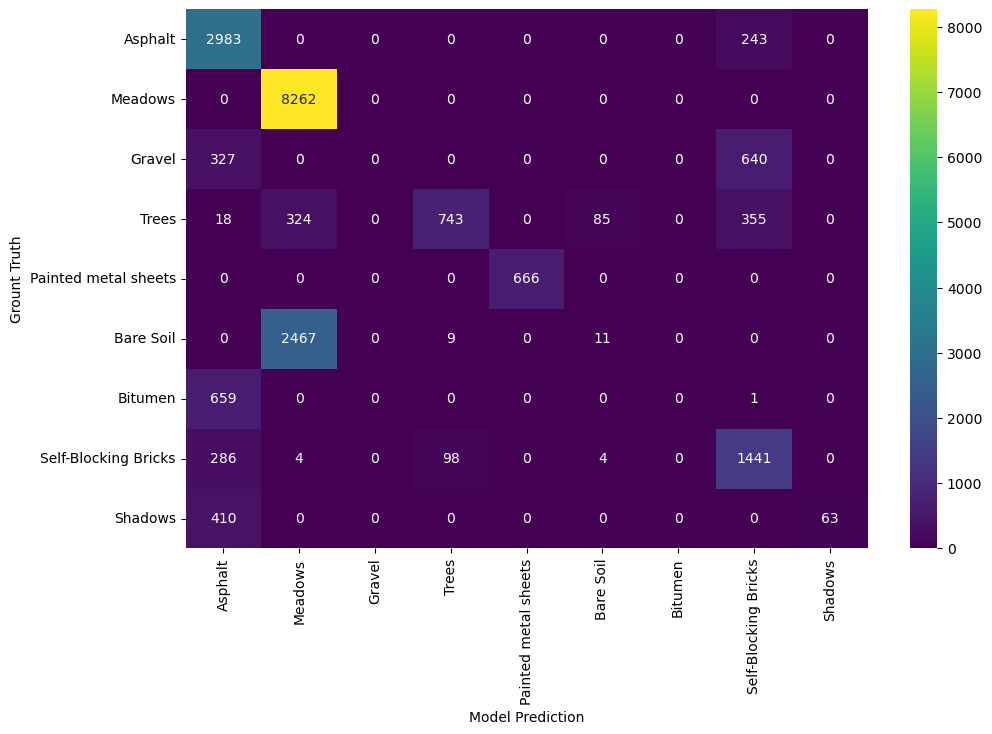

In [116]:
plt.subplots(1, 1, figsize=(11, 7))
ax = sns.heatmap(
    results["cm"],
    cmap="viridis",
    fmt="g",
    xticklabels=active_cl_names,
    yticklabels=active_cl_names,
    annot=True,
)
ax.set(xlabel="Model Prediction", ylabel="Grount Truth")
plt.show()